# Machine-Learning Assignment

The main task of the assignment is to study model selection that takes into account accuracy
and fairness metrics when training the machine learning models. The task is to compare standard
machine learning models versus fairness-based machine learning models with the following model
selection criteria: most accurate, most fair, and most accurate+fair (extra).

# Pre-processing

This assignment is being written in Google Colab and thus will contain lines used to download the AIF360, and Fairlearn libraries + the data used in the assignment.  

## Downloading Adult & German datasets

Downloading the datasets that is required for the assignment. The datasets are downloaded from the AIF360 dataset

In [ ]:
import warnings
warnings.filterwarnings('ignore')

AIF360 uses algorithms from the Fairlearn-library, version 0.4.6

In [ ]:
pip install fairlearn==0.4.6

In [ ]:
pip install AIF360

In [ ]:
cd /usr/local/lib/python3.7/dist-packages/aif360/data/raw/adult

/usr/local/lib/python3.7/dist-packages/aif360/data/raw/adult


In [ ]:
# Retrieving the adult dataset from the links below
!wget	https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
!wget	https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test
!wget	https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names

--2022-05-11 09:16:53--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3974305 (3.8M) [application/x-httpd-php]
Saving to: ‘adult.data.1’

adult.data.1        100%[===================>]   3.79M  3.61MB/s    in 1.1s    

2022-05-11 09:16:55 (3.61 MB/s) - ‘adult.data.1’ saved [3974305/3974305]

--2022-05-11 09:16:56--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2003153 (1.9M) [application/x-httpd-php]
Saving to: ‘adult.test.1’

adult.test.1        100%[===================>]   1.91M  2.09MB/s    in 0.9s    

In [ ]:
cd /usr/local/lib/python3.7/dist-packages/aif360/data/raw/german

/usr/local/lib/python3.7/dist-packages/aif360/data/raw/german


In [ ]:
# Retrieving the german dataset from the links below
!wget	https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.doc

--2022-05-11 09:16:58--  https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 79793 (78K) [application/x-httpd-php]
Saving to: ‘german.data.1’

german.data.1       100%[===================>]  77.92K   290KB/s    in 0.3s    

2022-05-11 09:16:59 (290 KB/s) - ‘german.data.1’ saved [79793/79793]

--2022-05-11 09:16:59--  https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.doc
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4679 (4.6K) [application/x-httpd-php]
Saving to: ‘german.doc.1’

german.doc.1        100%[===================>]   4.57K  --.-KB/s    i

## Importing the relevant libraries

In [ ]:
# Standard Python tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time, datetime
from typing import Callable
import itertools

# Tools for dataset importation
from aif360.datasets import AdultDataset, GermanDataset, StructuredDataset
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing.reweighing import Reweighing
from aif360.algorithms.inprocessing import ExponentiatedGradientReduction as EGR
from aif360.algorithms.preprocessing import OptimPreproc
from aif360.algorithms.preprocessing.optim_preproc_helpers.opt_tools import OptTools
from aif360.algorithms.preprocessing.optim_preproc_helpers.distortion_functions import get_distortion_adult, get_distortion_german

# Preprocessing tools
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

# Sklearn-tools
from sklearn.linear_model import LogisticRegression as logreg
from sklearn.tree import DecisionTreeClassifier as dtc
from sklearn.ensemble import RandomForestClassifier as rfc

## Splitting and Scaling of the datasets

The datasets are split using a 70/30 split and \
scaled using Standard Scaler $(z_i = \frac{(\bar{x} - x_i)}{σ})$ to standardize the datasets.

In [ ]:
label_map = {1.0: 'Good Credit', 0.0: 'Bad Credit'}
protected_attribute_maps = [{1.0: 'Male', 0.0: 'Female'}]
german = GermanDataset(protected_attribute_names=['sex'],
                       privileged_classes=[['male']],
                       metadata={'label_map': label_map,
                                 'protected_attribute_maps': protected_attribute_maps})

train_g, test_g = german.split([0.7], shuffle=True)

# Normalizing the datasets
scaler = StandardScaler()

train_g_s = train_g.copy()
train_g_s.features = scaler.fit_transform(train_g_s.features)
test_g_s = test_g.copy()
test_g_s.features = scaler.fit_transform(test_g_s.features)

x_train_g = scaler.fit_transform(train_g.features)
y_train_g = train_g.labels.ravel()
x_test_g = scaler.fit_transform(test_g.features)
y_test_g = test_g.labels.ravel()

In [ ]:
privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]
adult = load_preproc_data_adult(['sex'])

train_a, test_a = adult.split([0.7], shuffle=True)

# Normalizing the datasets
train_a_s = train_a.copy()
train_a_s.features = scaler.fit_transform(train_a_s.features)
test_a_s = test_a.copy()
test_a_s.features = scaler.fit_transform(test_a_s.features)

x_train_a = scaler.fit_transform(train_a.features)
y_train_a = train_a.labels.ravel()
x_test_a = scaler.transform(test_a.features) 
y_test_a = test_a.labels.ravel()

In [ ]:
print("German")
print(f"x_train: {x_train_g.shape}")
print(f"y_train: {y_train_g.shape}")
print(f"x_test: {x_test_g.shape}")
print(f"y_test: {y_test_g.shape}")
print("")
print("Adult")
print(f"x_train: {x_train_a.shape}")
print(f"y_train: {y_train_a.shape}")
print(f"x_test: {x_test_a.shape}")
print(f"y_test: {y_test_a.shape}")

German
x_train: (700, 58)
y_train: (700,)
x_test: (300, 58)
y_test: (300,)

Adult
x_train: (34189, 18)
y_train: (34189,)
x_test: (14653, 18)
y_test: (14653,)


# Task 1

The standard machine learning methods such as logistic regression, support vector machines, multi-layer perceptron use a trade-off hyperparameter (lambda, learning rate) to trade-off accuracy and generalisation (Lecture 5). The first task is to analyse whether or not better generalisation could correspond to fairer models.
Specifically, for a given machine learning model of your choice, use training data to perform 5-fold cross validation. By varying the trade-off hyperparameter, select the model with the highest accuracy, and the model with the best fairness metric across 5 folds 1
. After this model selection step, compute and report final accuracy and fairness metrics for both models and on the test set.

In [ ]:
class accurate:

    """This model is a Random Forest Classifier that is trained using a 5-fold cross-validation
    and tuned on 4 hyper-parameters."""
    
    def __init__(self, x_train, y_train, x_test, y_test, train, test, 
                 privileged_groups=privileged_groups, 
                 unprivileged_groups=unprivileged_groups):
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.train = train
        self.test = test
        self.privileged_groups = privileged_groups
        self.unprivileged_groups = unprivileged_groups

    def rfc_train(self, params):
        np.random.seed(8)
        self.data_rf = []
        self.params = params
        
        kf = KFold(n_splits=5) # 5-fold cross-validation
        param = list(itertools.product(*list(self.params.values()))) # Hyper-paramater tuning 
        for (criterion_, max_depth_, min_samples_split_, n_estimators_) in param:  # Parameters
            temp = []
            for train_idx, test_idx in kf.split(self.train.features):
                training_data = self.train.subset(train_idx)
                validation_data = self.train.subset(test_idx)

                # Random Forest Classifier (RFC)
                clf = rfc(criterion=criterion_,
                          max_depth=max_depth_,
                          min_samples_split=min_samples_split_,
                          n_estimators=n_estimators_,
                          random_state=64)
                # Fitting the RFC-model
                clf.fit(training_data.features, 
                        training_data.labels.ravel(), 
                        sample_weight=training_data.instance_weights)
                validation_preds = clf.predict(validation_data.features)
                pred_validation = validation_data.copy()
                pred_validation.labels = validation_preds

                # AIF-Classification Metric for accuracy and fairness
                fm_train = ClassificationMetric(validation_data, 
                           pred_validation, 
                           unprivileged_groups=self.unprivileged_groups, 
                           privileged_groups=self.privileged_groups)

                # Accuracy and fairness metrics
                temp.append([round(fm_train.accuracy() * 100, 3),
                             round((fm_train.precision() * fm_train.recall() * 2) /
                                   (fm_train.precision() + fm_train.recall()) * 100, 3),
                             round(fm_train.statistical_parity_difference(), 5),
                             round(fm_train.equal_opportunity_difference(), 5),
                             round(fm_train.average_odds_difference(), 5),
                             round((fm_train.true_positive_rate() + fm_train.true_negative_rate()) / 2, 5),
                             round(fm_train.disparate_impact(), 5)])
            temp_ = [criterion_, max_depth_, min_samples_split_, n_estimators_]
            temp_.extend( np.mean(temp, axis=0))
            self.data_rf.append(temp_)
        cols = ['Criterion', 'Max Depth', 'Min Samples Split', 'N Estimators', 
                'Accuracy', 'F1-Score', 'Statistical Parity', 'Equal Opportunity', 
                'Avg Odds', 'Balanced Accuracy', 'Disparate Impact']
        self.train_res = pd.DataFrame(self.data_rf, columns=cols)
        return self.train_res





    def rfc_test(self):
        metrics = ['Accuracy', 'Equal Opportunity'] # We use Equal Opportunity Difference to calculate the fairness
        model_test = {}
        for m in metrics:
            row_idx = self.train_res.iloc[self.train_res[m].idxmax()]
            params = row_idx[['Criterion', 'Max Depth', 'Min Samples Split', 'N Estimators']].tolist()
            clf = rfc(criterion=params[0],
                      max_depth=params[1],
                      min_samples_split=params[2],
                      n_estimators=params[3],
                      random_state=64)
            clf.fit(self.x_train, self.y_train)
            preds = clf.predict(self.x_test)
            test_predicted = self.test.copy()
            test_predicted.labels = preds

            fm_test = ClassificationMetric(self.test, test_predicted,
                                           unprivileged_groups=self.unprivileged_groups,
                                           privileged_groups=self.privileged_groups)
            
            model_test[m] = [params[0],
                             params[1],
                             params[2],
                             params[3],
                             round(fm_test.accuracy() * 100, 3),
                             round((fm_test.precision() * fm_test.recall() * 2) /
                                   (fm_test.precision() + fm_test.recall()) * 100, 3),
                             round(fm_test.statistical_parity_difference(), 5),
                             round(fm_test.equal_opportunity_difference(), 5),
                             round(fm_test.average_odds_difference(), 5),
                             round((fm_test.true_positive_rate() + fm_test.true_negative_rate()) / 2, 5),
                             round(fm_test.disparate_impact(), 5)]
        
        cols = ['Criterion', 'Max Depth', 'Min Samples Split', 'N Estimators', 
                'Accuracy', 'F1-Score','Statistical Parity', 'Equal Opportunity',
                'Avg Odds', 'Balanced Accuracy', 'Disparate Impact']
        testing_performance = pd.DataFrame.from_dict(model_test, orient='index', columns=cols)
        return testing_performance

In [ ]:
rf_params = {'criterion': ['gini', 'entropy'], 'max_depth': [50, 75, 100], 'min_samples_split': [2, 4, 8], 'n_estimators': [10, 20, 40, 60]}

## 1.1 Adult dataset

In [ ]:
acc_adult = accurate(x_train_a, y_train_a, x_test_a, y_test_a, train_a_s, test_a_s)
a_train_res = acc_adult.rfc_train(rf_params)
display(a_train_res)

,Criterion,Max Depth,Min Samples Split,N Estimators,Accuracy,F1-Score,Statistical Parity,Equal Opportunity,Avg Odds,Balanced Accuracy,Disparate Impact
0,gini,50,2,10,80.2950,48.2840,-0.214736,-0.458126,-0.284082,0.659834,0.0
1,gini,50,2,20,80.2920,48.2726,-0.214692,-0.457978,-0.284010,0.659770,0.0
2,gini,50,2,40,80.2922,48.2724,-0.214692,-0.457978,-0.284010,0.659770,0.0
3,gini,50,2,60,80.2952,48.2760,-0.214648,-0.457978,-0.283978,0.659790,0.0
4,gini,50,4,10,80.2980,48.2800,-0.214604,-0.457978,-0.283946,0.659808,0.0
...,...,...,...,...,...,...,...,...,...,...,...
67,entropy,100,4,60,80.2980,48.2798,-0.214604,-0.457978,-0.283946,0.659808,0.0
68,entropy,100,8,10,80.2978,48.2802,-0.214604,-0.457978,-0.283946,0.659810,0.0
69,entropy,100,8,20,80.2920,48.2726,-0.214692,-0.457978,-0.284010,0.659770,0.0
70,entropy,100,8,40,80.2922,48.2724,-0.214692,-0.457978,-0.284010,0.659770,0.0


In [ ]:
acc_adult.rfc_test()

,Criterion,Max Depth,Min Samples Split,N Estimators,Accuracy,F1-Score,Statistical Parity,Equal Opportunity,Avg Odds,Balanced Accuracy,Disparate Impact
Accuracy,gini,50,8,10,80.448,49.265,-0.21212,-0.45532,-0.27892,0.66398,0.0
Equal Opportunity,gini,50,2,20,80.448,49.265,-0.21212,-0.45532,-0.27892,0.66398,0.0


## 1.2 German dataset

In [ ]:
acc_german = accurate(x_train_g, y_train_g, x_test_g, y_test_g, train_g_s, test_g_s)
g_train_res = acc_german.rfc_train(rf_params)
display(g_train_res)

,Criterion,Max Depth,Min Samples Split,N Estimators,Accuracy,F1-Score,Statistical Parity,Equal Opportunity,Avg Odds,Balanced Accuracy,Disparate Impact
0,gini,50,2,10,75.8570,84.1878,-0.053824,-0.039002,-0.040660,0.647530,0.937526
1,gini,50,2,20,76.5714,84.5556,-0.045506,-0.020388,-0.038168,0.662880,0.945920
2,gini,50,2,40,75.7142,84.0134,-0.057214,-0.047046,-0.043266,0.652826,0.933152
3,gini,50,2,60,77.0000,84.8750,-0.052144,-0.041080,-0.025398,0.668012,0.939244
4,gini,50,4,10,75.4286,83.4774,-0.031998,-0.014694,-0.009862,0.667380,0.959718
...,...,...,...,...,...,...,...,...,...,...,...
67,entropy,100,4,60,76.5714,84.6206,-0.042556,-0.013584,-0.025284,0.656692,0.951664
68,entropy,100,8,10,76.1428,83.8744,-0.046494,-0.042874,-0.004936,0.673218,0.942594
69,entropy,100,8,20,75.5714,83.7750,-0.052916,-0.053524,-0.010888,0.657574,0.937506
70,entropy,100,8,40,74.1430,82.8304,-0.105922,-0.080730,-0.096372,0.636664,0.878146


In [ ]:
acc_german.rfc_test()

,Criterion,Max Depth,Min Samples Split,N Estimators,Accuracy,F1-Score,Statistical Parity,Equal Opportunity,Avg Odds,Balanced Accuracy,Disparate Impact
Accuracy,gini,50,8,60,73.667,82.937,-0.03492,-0.00877,-0.01588,0.61867,0.95926
Equal Opportunity,gini,50,4,20,71.333,81.057,-0.02381,-0.00439,-0.00507,0.60503,0.97110


## 1.3 Analysis

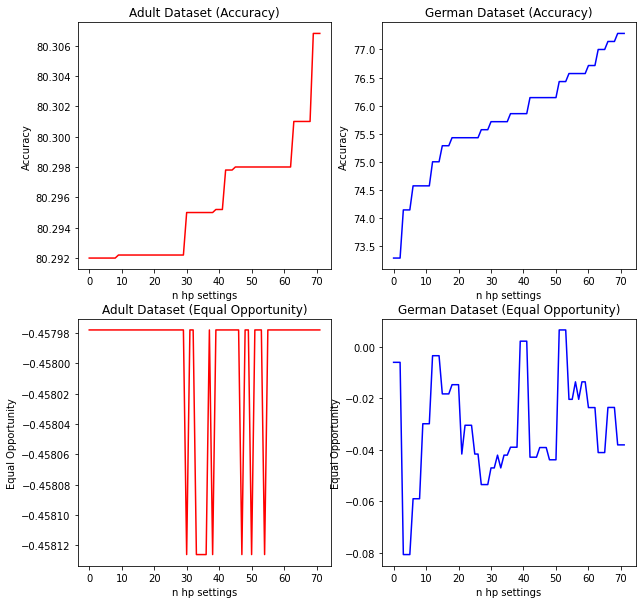

The correlation in the Adult dataset: -0.03244
The correlation in the German dataset: 0.1283
The mean accuracy in the Adult dataset: 80.29567499999997
The mean equal opportunity difference in the Adult dataset: -0.45799650000000036
The mean accuracy in the German dataset: 75.74998333333333
The mean equal opportunity difference in the German dataset: -0.03096483333333333


In [ ]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(range(a_train_res.shape[0]), a_train_res.sort_values(by=['Accuracy'])['Accuracy'], c='red')
plt.title("Adult Dataset (Accuracy)")
plt.xlabel("n hp settings")
plt.ylabel("Accuracy")

plt.subplot(2, 2, 2)
plt.plot(range(g_train_res.shape[0]), g_train_res.sort_values(by=['Accuracy'])['Accuracy'], c='blue')
plt.title("German Dataset (Accuracy)")
plt.xlabel("n hp settings")
plt.ylabel("Accuracy")

plt.subplot(2, 2, 3)
plt.plot(range(a_train_res.shape[0]), a_train_res.sort_values(by=['Accuracy'])['Equal Opportunity'], c='red')
plt.title("Adult Dataset (Equal Opportunity)")
plt.xlabel("n hp settings")
plt.ylabel('Equal Opportunity')

plt.subplot(2, 2, 4)
plt.plot(range(g_train_res.shape[0]), g_train_res.sort_values(by=['Accuracy'])['Equal Opportunity'], c='blue')
plt.title("German Dataset (Equal Opportunity)")
plt.xlabel("n hp settings")
plt.ylabel('Equal Opportunity')

plt.show()

print(f"The correlation in the Adult dataset: {a_train_res['Accuracy'].corr(a_train_res['Equal Opportunity']).round(5)}")
print(f"The correlation in the German dataset: {g_train_res['Accuracy'].corr(g_train_res['Equal Opportunity']).round(5)}")
print(f"The mean accuracy in the Adult dataset: {a_train_res['Accuracy'].mean()}")
print(f"The mean equal opportunity difference in the Adult dataset: {a_train_res['Equal Opportunity'].mean()}")
print(f"The mean accuracy in the German dataset: {g_train_res['Accuracy'].mean()}")
print(f"The mean equal opportunity difference in the German dataset: {g_train_res['Equal Opportunity'].mean()}")

# Task 2

Now choose an algorithmic fairness method, e.g. reweighing (Lecture 7), and perform
the same analysis, i.e. how varying the hyperparameter(s) impacts accuracy and fairness metrics
during model selection.
Specifically, using the same 5-fold cross validation as in Task 1, perform validation by varying
the trade-off hyperparameter and select (3) the model with the highest accuracy, and (4) the
model with the best fairness metric across 5 folds. After model selection, compute and report
final accuracy and fairness for both models (3) and (4) on the test set.

In [ ]:
class fairness:
    def __init__(self, x_train, y_train, x_test, y_test, train, test, 
                 privileged_groups=privileged_groups, 
                 unprivileged_groups=unprivileged_groups):
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.train = train
        self.test = test
        self.privileged_groups = privileged_groups
        self.unprivileged_groups = unprivileged_groups

    def rfc_train(self, params):
        np.random.seed(8)
        self.data_rf = []
        self.params = params
        
        kf = KFold(n_splits=5) # 5-fold cross-validation
        param = list(itertools.product(*list(self.params.values()))) # Hyper-paramater tuning
        for (criterion_, max_depth_, min_samples_split_, n_estimators_) in param:
            temp = []
            for train_idx, test_idx in kf.split(self.train.features):
                training_data = self.train.subset(train_idx)
                validation_data = self.train.subset(test_idx)
                # Random Forest Classifier (RFC)
                clf = rfc(criterion=criterion_,
                          max_depth=max_depth_,
                          min_samples_split=min_samples_split_,
                          n_estimators=n_estimators_,
                          random_state=64)
                # Using Exponentiated Gradient Reduction to reduce Equal Opportunity Difference at the in-processing stage
                egr_clf = EGR(estimator=clf, constraints="EqualizedOdds", drop_prot_attr=False) ############################################
                egr_clf.fit(training_data)                            ############################################
                validation_preds = egr_clf.predict(validation_data)   ############################################
                # AIF-Classification Metric for accuracy and fairness
                fm_train = ClassificationMetric(validation_data, 
                           validation_preds, 
                           unprivileged_groups=self.unprivileged_groups, 
                           privileged_groups=self.privileged_groups)

                # Accuracy and fairness metrics
                temp.append([round(fm_train.accuracy() * 100, 3),
                                   round((fm_train.precision() * fm_train.recall() * 2) /
                                         (fm_train.precision() + fm_train.recall()) * 100, 3),
                                   round(fm_train.statistical_parity_difference(), 5),
                                   round(fm_train.equal_opportunity_difference(), 5),
                                   round(fm_train.average_odds_difference(), 5),
                                   round((fm_train.true_positive_rate() + fm_train.true_negative_rate()) / 2, 5),
                                   round(fm_train.disparate_impact(), 5)])
            temp_ = [criterion_, max_depth_, min_samples_split_, n_estimators_]
            temp_.extend(np.mean(temp, axis=0))
            self.data_rf.append(temp_)
        cols = ['Criterion', 'Max Depth', 'Min Samples Split', 'N Estimators', 
                'Accuracy', 'F1-Score', 'Statistical Parity', 'Equal Opportunity',
                'Avg Odds', 'Balanced Accuracy', 'Disparate Impact']
        self.train_res = pd.DataFrame(self.data_rf, columns=cols)
        return self.train_res




    def rfc_test(self):
        metrics = ['Accuracy', 'Equal Opportunity']
        model_test = {}
        for m in metrics:
            row_idx = self.train_res.iloc[self.train_res[m].idxmax()]
            params = row_idx[['Criterion', 'Max Depth', 'Min Samples Split', 'N Estimators']].tolist()

            clf = rfc(criterion=params[0],
                      max_depth=params[1],
                      min_samples_split=params[2],
                      n_estimators=params[3],
                      random_state=64)
            egr_clf = EGR(estimator=clf, constraints="EqualizedOdds", drop_prot_attr=False)
            egr_clf.fit(self.train)
            preds = egr_clf.predict(self.test)

            fm_test = ClassificationMetric(self.test,
                                           preds,
                                           unprivileged_groups=self.unprivileged_groups,
                                           privileged_groups=self.privileged_groups)
            
            model_test[m] = [params[0],
                             params[1],
                             params[2],
                             params[3],
                             round(fm_test.accuracy() * 100, 3),
                             round((fm_test.precision() * fm_test.recall() * 2) /
                                   (fm_test.precision() + fm_test.recall()) * 100, 3),
                             round(fm_test.statistical_parity_difference(), 5),
                             round(fm_test.equal_opportunity_difference(), 5),
                             round(fm_test.average_odds_difference(), 5),
                             round((fm_test.true_positive_rate() + fm_test.true_negative_rate()) / 2, 5),
                             round(fm_test.disparate_impact(), 5)]
        
        cols = ['Criterion', 'Max Depth', 'Min Samples Split', 'N Estimators', 
                'Accuracy', 'F1-Score', 'Statistical Parity', 'Equal Opportunity',
                'Avg Odds', 'Balanced Accuracy', 'Disparate Impact']
        test_data = pd.DataFrame.from_dict(model_test, orient='index', columns=cols)
        return pd.DataFrame.from_dict(model_test, orient='index', columns=cols)

## 2.1 Adult

Due to the implementation of the EGR in-processing technique, I'll reduce the number of different hyper-parameters to improve the run-time. This is done purely to improve run-time, but should still be useful as a proof-of-concept

In [ ]:
rf_params = {'criterion': ['gini', 'entropy'], 'max_depth': [50, 100], 'min_samples_split': [2, 8], 'n_estimators': [20, 60]}

In [ ]:
fair_adult = fairness(x_train_a, y_train_a, x_test_a, y_test_a, train_a_s, test_a_s)
fair_a = fair_adult.rfc_train(rf_params)
display(fair_a)

,Criterion,Max Depth,Min Samples Split,N Estimators,Accuracy,F1-Score,Statistical Parity,Equal Opportunity,Avg Odds,Balanced Accuracy,Disparate Impact
0,gini,50,2,20,79.0664,49.9110,-0.072758,-0.017498,-0.012384,0.669536,0.645072
1,gini,50,2,60,79.0868,49.8832,-0.072108,-0.014586,-0.010824,0.669366,0.646928
2,gini,50,8,20,79.0576,49.9064,-0.072846,-0.017628,-0.012496,0.669516,0.644866
3,gini,50,8,60,79.0838,49.9232,-0.072940,-0.017264,-0.012380,0.669614,0.643816
4,gini,100,2,20,79.0342,49.7576,-0.071572,-0.015152,-0.010896,0.668630,0.649372
5,gini,100,2,60,79.0926,49.9490,-0.072848,-0.017638,-0.012456,0.669756,0.644350
6,gini,100,8,20,79.0602,49.8744,-0.072100,-0.015968,-0.011398,0.669320,0.647606
7,gini,100,8,60,79.1160,50.0058,-0.072452,-0.017284,-0.011988,0.670076,0.646082
8,entropy,50,2,20,79.0518,49.9350,-0.073110,-0.017436,-0.012540,0.669694,0.644192
9,entropy,50,2,60,79.0782,49.9018,-0.072454,-0.016972,-0.011990,0.669484,0.645888


In [ ]:
fair_adult.rfc_test()

,Criterion,Max Depth,Min Samples Split,N Estimators,Accuracy,F1-Score,Statistical Parity,Equal Opportunity,Avg Odds,Balanced Accuracy,Disparate Impact
Accuracy,gini,100,8,60,79.062,50.786,-0.08011,-0.03441,-0.01983,0.67313,0.61628
Equal Opportunity,gini,50,2,60,79.090,50.866,-0.08031,-0.03539,-0.02025,0.67360,0.61568


## 2.2 German

In [ ]:
fair_german = fairness(x_train_g, y_train_g, x_test_g, y_test_g, train_g_s, test_g_s)
fair_g = fair_german.rfc_train(rf_params)
display(fair_g)

,Criterion,Max Depth,Min Samples Split,N Estimators,Accuracy,F1-Score,Statistical Parity,Equal Opportunity,Avg Odds,Balanced Accuracy,Disparate Impact
0,gini,50,2,20,75.9998,84.1510,-0.036086,0.000250,-0.035374,0.657146,0.958080
1,gini,50,2,60,77.0000,84.8750,-0.052144,-0.041080,-0.025398,0.668012,0.939244
2,gini,50,8,20,76.1428,84.2134,-0.016762,0.013876,0.004860,0.658304,0.981218
3,gini,50,8,60,75.2854,83.8622,-0.048344,-0.054746,-0.012974,0.644602,0.943866
4,gini,100,2,20,75.9998,84.1510,-0.036086,0.000250,-0.035374,0.657146,0.958080
5,gini,100,2,60,77.0000,84.8750,-0.052144,-0.041080,-0.025398,0.668012,0.939244
6,gini,100,8,20,74.8572,83.4430,-0.060092,-0.018116,-0.052426,0.639336,0.932598
7,gini,100,8,60,76.5716,84.6242,-0.076994,-0.057550,-0.048426,0.665000,0.910414
8,entropy,50,2,20,76.0002,84.2584,-0.032562,-0.008184,-0.020706,0.650222,0.963300
9,entropy,50,2,60,75.7142,84.0042,-0.064138,-0.042078,-0.042834,0.658448,0.923814


In [ ]:
fair_german.rfc_test()

,Criterion,Max Depth,Min Samples Split,N Estimators,Accuracy,F1-Score,Statistical Parity,Equal Opportunity,Avg Odds,Balanced Accuracy,Disparate Impact
Accuracy,gini,50,2,60,72.333,82.151,-0.02857,-0.00219,-0.01468,0.59979,0.96685
Equal Opportunity,gini,50,8,20,69.667,80.174,-0.04762,-0.05263,-0.02475,0.57755,0.94382


## 2.3 Analysis

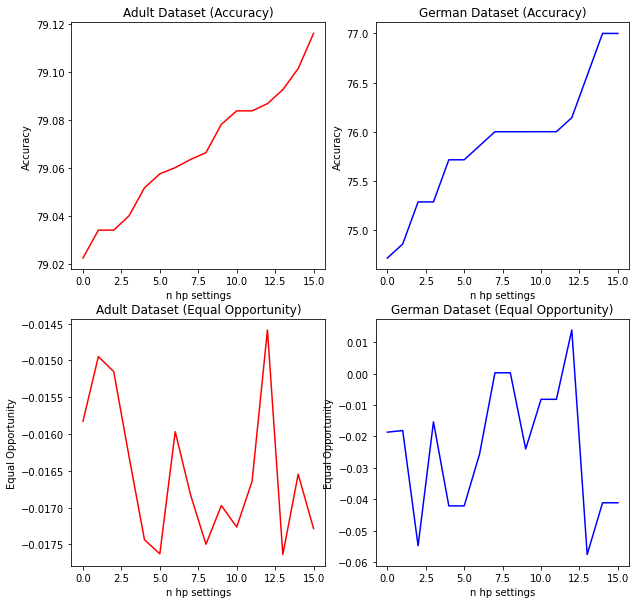

The correlation in the Adult dataset: -0.40466
The correlation in the German dataset: -0.17228
The mean accuracy in the Adult dataset: 79.06708749999999
The mean equal opportunity difference in the Adult dataset: -0.016533
The mean accuracy in the German dataset: 75.88390000000001
The mean equal opportunity difference in the German dataset: -0.023890500000000002


In [ ]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(range(fair_a.shape[0]), fair_a.sort_values(by=['Accuracy'])['Accuracy'], c='red')
plt.title("Adult Dataset (Accuracy)")
plt.xlabel("n hp settings")
plt.ylabel("Accuracy")

plt.subplot(2, 2, 2)
plt.plot(range(fair_g.shape[0]), fair_g.sort_values(by=['Accuracy'])['Accuracy'], c='blue')
plt.title("German Dataset (Accuracy)")
plt.xlabel("n hp settings")
plt.ylabel("Accuracy")

plt.subplot(2, 2, 3)
plt.plot(range(fair_a.shape[0]), fair_a.sort_values(by=['Accuracy'])['Equal Opportunity'], c='red')
plt.title("Adult Dataset (Equal Opportunity)")
plt.xlabel("n hp settings")
plt.ylabel('Equal Opportunity')

plt.subplot(2, 2, 4)
plt.plot(range(fair_g.shape[0]), fair_g.sort_values(by=['Accuracy'])['Equal Opportunity'], c='blue')
plt.title("German Dataset (Equal Opportunity)")
plt.xlabel("n hp settings")
plt.ylabel('Equal Opportunity')

plt.show()

print(f"The correlation in the Adult dataset: {fair_a['Accuracy'].corr(fair_a['Equal Opportunity']).round(5)}")
print(f"The correlation in the German dataset: {fair_g['Accuracy'].corr(fair_g['Equal Opportunity']).round(5)}")
print(f"The mean accuracy in the Adult dataset: {fair_a['Accuracy'].mean()}")
print(f"The mean equal opportunity difference in the Adult dataset: {fair_a['Equal Opportunity'].mean()}")
print(f"The mean accuracy in the German dataset: {fair_g['Accuracy'].mean()}")
print(f"The mean equal opportunity difference in the German dataset: {fair_g['Equal Opportunity'].mean()}")

# Task 3

Based on your observations, suggest a model selection strategy (criterion)
that accounts for both, accuracy and fairness. Compare the standard machine learning model
versus the fairness-based machine learning model using the proposed criterion - what is the effect
(if any)?

Specifically, using the same 5-fold cross validation as before, select (5) the standard machine
learning model (studied in Task 1), and (6) the fairness-based model (studied in Task 2) based
on the proposed accuracy+fairness criterion. After model selection, compute and report final
accuracy and fairness for both models (5) and (6) on the test set.

In [ ]:
class fair_accurate:
      
    """This model is completely similar to the fairness-model in Q2, except
    that this model measures the Accuracy minus the absolute value of the 
    Equal Opportunity Difference:
    Accuracy - abs(Equal_Opportunity) = Highest Accuracy with Regards 
    to the most Equal Opportunities"""


    def __init__(self, x_train, y_train, x_test, y_test, train, test, privileged_groups=privileged_groups, unprivileged_groups=unprivileged_groups):
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.train = train
        self.test = test
        self.privileged_groups = privileged_groups
        self.unprivileged_groups = unprivileged_groups

    def rfc_train(self, params):
        np.random.seed(8)
        self.data_rf = []
        self.params = params
        
        kf = KFold(n_splits=5) # 5-fold cross-validation
        param = list(itertools.product(*list(self.params.values()))) # Creates a list of every hyper-param setting
        for (criterion_, max_depth_, min_samples_split_, n_estimators_) in param:
            temp = []
            for train_idx, test_idx in kf.split(self.train.features):
                training_data = self.train.subset(train_idx)
                validation_data = self.train.subset(test_idx)
                # Random Forest Classifier (RFC)
                clf = rfc(criterion=criterion_,
                          max_depth=max_depth_,
                          min_samples_split=min_samples_split_,
                          n_estimators=n_estimators_,
                          random_state=64)
                # Using Exponentiated Gradient Reduction to reduce Equal Opportunity Difference at the in-processing stage
                egr_clf = EGR(estimator=clf, constraints="EqualizedOdds", drop_prot_attr=False) ############################################
                egr_clf.fit(training_data)                            ############################################
                validation_preds = egr_clf.predict(validation_data)   ############################################
                # AIF-Classification Metric for accuracy and fairness
                fm_train = ClassificationMetric(validation_data, 
                           validation_preds, 
                           unprivileged_groups=self.unprivileged_groups, 
                           privileged_groups=self.privileged_groups)

                # Accuracy and fairness metrics
                temp.append([round(fm_train.accuracy() * 100, 3),
                             round((fm_train.precision() * fm_train.recall() * 2) /
                                   (fm_train.precision() + fm_train.recall()) * 100, 3),
                             round(fm_train.accuracy() - np.abs(fm_train.equal_opportunity_difference()), 3),
                             round(fm_train.accuracy() - fm_train.equal_opportunity_difference()**2, 3),
                             round(fm_train.statistical_parity_difference(), 5),
                             round(fm_train.equal_opportunity_difference(), 5),
                             round(fm_train.average_odds_difference(), 5),
                             round((fm_train.true_positive_rate() + fm_train.true_negative_rate()) / 2, 5),
                             round(fm_train.disparate_impact(), 5)])
            temp_ = [criterion_, max_depth_, min_samples_split_, n_estimators_]
            temp_.extend(np.mean(temp, axis=0))
            self.data_rf.append(temp_)
        cols = ['Criterion', 'Max Depth', 'Min Samples Split', 'N Estimators', 
                'Accuracy', 'F1-Score', 'Acc - abs(Equal Opp)', 'Acc - Equal Opp^2', 'Statistical Parity',
                'Equal Opportunity', 'Avg Odds', 'Balanced Accuracy', 'Disparate Impact']
        self.train_res = pd.DataFrame(self.data_rf, columns=cols)
        return self.train_res




    def rfc_test(self):
        metrics = ['Accuracy', 'Equal Opportunity', 'Acc - abs(Equal Opp)', 'Acc - Equal Opp^2']
        model_test = {}
        for m in metrics:
            row_idx = self.train_res.iloc[self.train_res[m].idxmax()]
            params = row_idx[['Criterion', 'Max Depth', 'Min Samples Split', 'N Estimators']].tolist()

            clf = rfc(criterion=params[0],
                      max_depth=params[1],
                      min_samples_split=params[2],
                      n_estimators=params[3],
                      random_state=64)
            egr_clf = EGR(estimator=clf, constraints="EqualizedOdds", drop_prot_attr=False)
            egr_clf.fit(self.train)
            preds = egr_clf.predict(self.test)

            fm_test = ClassificationMetric(self.test,
                                           preds,
                                           unprivileged_groups=self.unprivileged_groups,
                                           privileged_groups=self.privileged_groups)
            
            model_test[m] = [params[0],
                             params[1],
                             params[2],
                             params[3],
                             round(fm_test.accuracy() * 100, 3),
                             round((fm_test.precision() * fm_test.recall() * 2) /
                                   (fm_test.precision() + fm_test.recall()) * 100, 3),
                             round(fm_test.accuracy() - np.abs(fm_test.equal_opportunity_difference()), 3),
                             round(fm_test.accuracy() - fm_test.equal_opportunity_difference()**2, 3),
                             round(fm_test.statistical_parity_difference(), 5),
                             round(fm_test.equal_opportunity_difference(), 5),
                             round(fm_test.average_odds_difference(), 5),
                             round((fm_test.true_positive_rate() + fm_test.true_negative_rate()) / 2, 5),
                             round(fm_test.disparate_impact(), 5)]
        
        cols = ['Criterion', 'Max Depth', 'Min Samples Split', 'N Estimators', 
                'Accuracy', 'F1-Score', 'Acc - abs(Equal Opp)', 'Acc - Equal Opp^2',  'Statistical Parity',
                'Equal Opportunity', 'Avg Odds', 'Balanced Accuracy', 'Disparate Impact']
        test_data = pd.DataFrame.from_dict(model_test, orient='index', columns=cols)
        return pd.DataFrame.from_dict(model_test, orient='index', columns=cols)

## 3.1 Adult

In [ ]:
facc_adult = fair_accurate(x_train_a, y_train_a, x_test_a, y_test_a, train_a_s, test_a_s)
facc_train_a = facc_adult.rfc_train(rf_params)
display(facc_train_a)

,Criterion,Max Depth,Min Samples Split,N Estimators,Accuracy,F1-Score,Acc - abs(Equal Opp),Acc - Equal Opp^2,Statistical Parity,Equal Opportunity,Avg Odds,Balanced Accuracy,Disparate Impact
0,gini,50,2,20,79.0664,49.9110,0.7622,0.7898,-0.072758,-0.017498,-0.012384,0.669536,0.645072
1,gini,50,2,60,79.0868,49.8832,0.7666,0.7902,-0.072108,-0.014586,-0.010824,0.669366,0.646928
2,gini,50,8,20,79.0576,49.9064,0.7632,0.7896,-0.072846,-0.017628,-0.012496,0.669516,0.644866
3,gini,50,8,60,79.0838,49.9232,0.7646,0.7898,-0.072940,-0.017264,-0.012380,0.669614,0.643816
4,gini,100,2,20,79.0342,49.7576,0.7628,0.7892,-0.071572,-0.015152,-0.010896,0.668630,0.649372
5,gini,100,2,60,79.0926,49.9490,0.7634,0.7898,-0.072848,-0.017638,-0.012456,0.669756,0.644350
6,gini,100,8,20,79.0602,49.8744,0.7640,0.7896,-0.072100,-0.015968,-0.011398,0.669320,0.647606
7,gini,100,8,60,79.1160,50.0058,0.7650,0.7904,-0.072452,-0.017284,-0.011988,0.670076,0.646082
8,entropy,50,2,20,79.0518,49.9350,0.7628,0.7896,-0.073110,-0.017436,-0.012540,0.669694,0.644192
9,entropy,50,2,60,79.0782,49.9018,0.7642,0.7900,-0.072454,-0.016972,-0.011990,0.669484,0.645888


In [ ]:
facc_adult.rfc_test()

,Criterion,Max Depth,Min Samples Split,N Estimators,Accuracy,F1-Score,Acc - abs(Equal Opp),Acc - Equal Opp^2,Statistical Parity,Equal Opportunity,Avg Odds,Balanced Accuracy,Disparate Impact
Accuracy,gini,100,8,60,79.062,50.786,0.756,0.789,-0.08011,-0.03441,-0.01983,0.67313,0.61628
Equal Opportunity,gini,50,2,60,79.090,50.866,0.756,0.790,-0.08031,-0.03539,-0.02025,0.67360,0.61568
Acc - abs(Equal Opp),gini,50,2,60,79.062,50.770,0.757,0.789,-0.07990,-0.03408,-0.01959,0.67304,0.61688
Acc - Equal Opp^2,gini,100,8,60,79.083,50.842,0.756,0.790,-0.08021,-0.03506,-0.02008,0.67346,0.61598


## 3.2 German

In [ ]:
facc_german = fair_accurate(x_train_g, y_train_g, x_test_g, y_test_g, train_g_s, test_g_s)
facc_train_g = facc_german.rfc_train(rf_params)
display(facc_train_g)

,Criterion,Max Depth,Min Samples Split,N Estimators,Accuracy,F1-Score,Acc - abs(Equal Opp),Acc - Equal Opp^2,Statistical Parity,Equal Opportunity,Avg Odds,Balanced Accuracy,Disparate Impact
0,gini,50,2,20,75.9998,84.1510,0.7098,0.7568,-0.036086,0.000250,-0.035374,0.657146,0.958080
1,gini,50,2,60,77.0000,84.8750,0.7240,0.7660,-0.052144,-0.041080,-0.025398,0.668012,0.939244
2,gini,50,8,20,76.1428,84.2134,0.7278,0.7602,-0.016762,0.013876,0.004860,0.658304,0.981218
3,gini,50,8,60,75.2854,83.8622,0.6984,0.7492,-0.048344,-0.054746,-0.012974,0.644602,0.943866
4,gini,100,2,20,75.9998,84.1510,0.7098,0.7568,-0.036086,0.000250,-0.035374,0.657146,0.958080
5,gini,100,2,60,77.0000,84.8750,0.7240,0.7660,-0.052144,-0.041080,-0.025398,0.668012,0.939244
6,gini,100,8,20,74.8572,83.4430,0.7102,0.7468,-0.060092,-0.018116,-0.052426,0.639336,0.932598
7,gini,100,8,60,76.5716,84.6242,0.6972,0.7594,-0.076994,-0.057550,-0.048426,0.665000,0.910414
8,entropy,50,2,20,76.0002,84.2584,0.7360,0.7594,-0.032562,-0.008184,-0.020706,0.650222,0.963300
9,entropy,50,2,60,75.7142,84.0042,0.7148,0.7550,-0.064138,-0.042078,-0.042834,0.658448,0.923814


In [ ]:
facc_german.rfc_test()

,Criterion,Max Depth,Min Samples Split,N Estimators,Accuracy,F1-Score,Acc - abs(Equal Opp),Acc - Equal Opp^2,Statistical Parity,Equal Opportunity,Avg Odds,Balanced Accuracy,Disparate Impact
Accuracy,gini,50,2,60,72.333,82.151,0.721,0.723,-0.02857,-0.00219,-0.01468,0.59979,0.96685
Equal Opportunity,gini,50,8,20,69.667,80.174,0.644,0.694,-0.04762,-0.05263,-0.02475,0.57755,0.94382
Acc - abs(Equal Opp),entropy,50,2,20,72.333,81.678,0.710,0.723,-0.03492,0.01316,-0.02660,0.61841,0.95761
Acc - Equal Opp^2,gini,50,2,60,72.333,82.151,0.721,0.723,-0.02857,-0.00219,-0.01468,0.59979,0.96685


## 3.3 Analysis

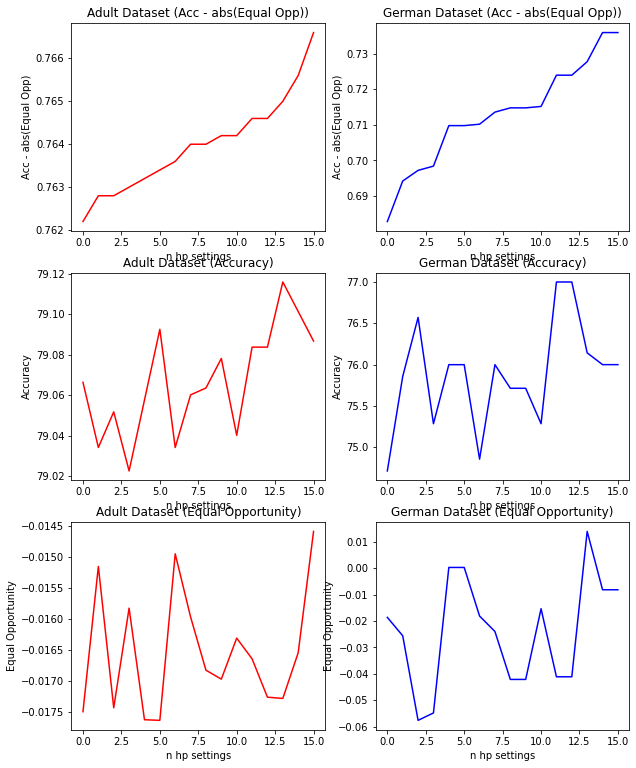

In [ ]:
plt.figure(figsize=(10, 13))

plt.subplot(3, 2, 1)
plt.plot(range(facc_train_a.shape[0]), facc_train_a.sort_values(by=['Acc - abs(Equal Opp)'])['Acc - abs(Equal Opp)'], c='red')
plt.title("Adult Dataset (Acc - abs(Equal Opp))")
plt.xlabel("n hp settings")
plt.ylabel('Acc - abs(Equal Opp)')

plt.subplot(3, 2, 2)
plt.plot(range(facc_train_g.shape[0]), facc_train_g.sort_values(by=['Acc - abs(Equal Opp)'])['Acc - abs(Equal Opp)'], c='blue')
plt.title("German Dataset (Acc - abs(Equal Opp))")
plt.xlabel("n hp settings")
plt.ylabel('Acc - abs(Equal Opp)')


plt.subplot(3, 2, 3)
plt.plot(range(facc_train_a.shape[0]), facc_train_a.sort_values(by=['Acc - abs(Equal Opp)'])['Accuracy'], c='red')
plt.title("Adult Dataset (Accuracy)")
plt.xlabel("n hp settings")
plt.ylabel("Accuracy")

plt.subplot(3, 2, 4)
plt.plot(range(facc_train_g.shape[0]), facc_train_g.sort_values(by=['Acc - abs(Equal Opp)'])['Accuracy'], c='blue')
plt.title("German Dataset (Accuracy)")
plt.xlabel("n hp settings")
plt.ylabel("Accuracy")

plt.subplot(3, 2, 5)
plt.plot(range(facc_train_a.shape[0]), facc_train_a.sort_values(by=['Acc - abs(Equal Opp)'])['Equal Opportunity'], c='red')
plt.title("Adult Dataset (Equal Opportunity)")
plt.xlabel("n hp settings")
plt.ylabel('Equal Opportunity')

plt.subplot(3, 2, 6)
plt.plot(range(facc_train_g.shape[0]), facc_train_g.sort_values(by=['Acc - abs(Equal Opp)'])['Equal Opportunity'], c='blue')
plt.title("German Dataset (Equal Opportunity)")
plt.xlabel("n hp settings")
plt.ylabel('Equal Opportunity')




plt.show()

print(f"Adult - Accuracy correlation with (Acc - abs(Equal Opp)): {facc_train_a['Acc - abs(Equal Opp)'].corr(facc_train_a['Accuracy']).round(5)}")
print(f"German - Accuracy correlation with (Acc - abs(Equal Opp)): {facc_train_g['Acc - abs(Equal Opp)'].corr(facc_train_g['Accuracy']).round(5)}")
print(f"Adult - Equal Opportunity correlation with (Acc - abs(Equal Opp)): {facc_train_a['Acc - abs(Equal Opp)'].corr(facc_train_a['Equal Opportunity']).round(5)}")
print(f"German - Equal Opportunity correlation with (Acc - abs(Equal Opp)): {facc_train_g['Acc - abs(Equal Opp)'].corr(facc_train_g['Equal Opportunity']).round(5)}")

Adult - Accuracy correlation with (Acc - abs(Equal Opp)): 0.62131
German - Accuracy correlation with (Acc - abs(Equal Opp)): 0.47065
Adult - Equal Opportunity correlation with (Acc - abs(Equal Opp)): 0.30288
German - Equal Opportunity correlation with (Acc - abs(Equal Opp)): 0.33181


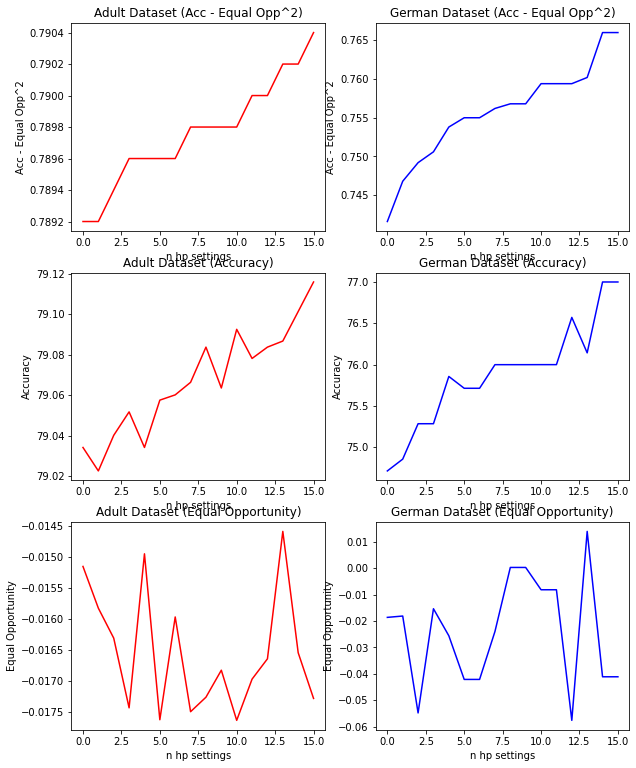

Adult - Accuracy correlation with (Acc - Equal Opp^2): 0.925
German - Accuracy correlation with (Acc - Equal Opp^2): 0.96671
Adult - Equal Opportunity correlation with (Acc - Equal Opp^2): -0.22731
German - Equal Opportunity correlation with (Acc - Equal Opp^2): -0.03912


In [ ]:
plt.figure(figsize=(10, 13))

plt.subplot(3, 2, 1)
plt.plot(range(facc_train_a.shape[0]), facc_train_a.sort_values(by=['Acc - Equal Opp^2'])['Acc - Equal Opp^2'], c='red')
plt.title("Adult Dataset (Acc - Equal Opp^2)")
plt.xlabel("n hp settings")
plt.ylabel('Acc - Equal Opp^2')

plt.subplot(3, 2, 2)
plt.plot(range(facc_train_g.shape[0]), facc_train_g.sort_values(by=['Acc - Equal Opp^2'])['Acc - Equal Opp^2'], c='blue')
plt.title("German Dataset (Acc - Equal Opp^2)")
plt.xlabel("n hp settings")
plt.ylabel('Acc - Equal Opp^2')


plt.subplot(3, 2, 3)
plt.plot(range(facc_train_a.shape[0]), facc_train_a.sort_values(by=['Acc - Equal Opp^2'])['Accuracy'], c='red')
plt.title("Adult Dataset (Accuracy)")
plt.xlabel("n hp settings")
plt.ylabel("Accuracy")

plt.subplot(3, 2, 4)
plt.plot(range(facc_train_g.shape[0]), facc_train_g.sort_values(by=['Acc - Equal Opp^2'])['Accuracy'], c='blue')
plt.title("German Dataset (Accuracy)")
plt.xlabel("n hp settings")
plt.ylabel("Accuracy")

plt.subplot(3, 2, 5)
plt.plot(range(facc_train_a.shape[0]), facc_train_a.sort_values(by=['Acc - Equal Opp^2'])['Equal Opportunity'], c='red')
plt.title("Adult Dataset (Equal Opportunity)")
plt.xlabel("n hp settings")
plt.ylabel('Equal Opportunity')

plt.subplot(3, 2, 6)
plt.plot(range(facc_train_g.shape[0]), facc_train_g.sort_values(by=['Acc - Equal Opp^2'])['Equal Opportunity'], c='blue')
plt.title("German Dataset (Equal Opportunity)")
plt.xlabel("n hp settings")
plt.ylabel('Equal Opportunity')




plt.show()

print(f"Adult - Accuracy correlation with (Acc - Equal Opp^2): {facc_train_a['Acc - Equal Opp^2'].corr(facc_train_a['Accuracy']).round(5)}")
print(f"German - Accuracy correlation with (Acc - Equal Opp^2): {facc_train_g['Acc - Equal Opp^2'].corr(facc_train_g['Accuracy']).round(5)}")
print(f"Adult - Equal Opportunity correlation with (Acc - Equal Opp^2): {facc_train_a['Acc - Equal Opp^2'].corr(facc_train_a['Equal Opportunity']).round(5)}")
print(f"German - Equal Opportunity correlation with (Acc - Equal Opp^2): {facc_train_g['Acc - Equal Opp^2'].corr(facc_train_g['Equal Opportunity']).round(5)}")